In [1]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("diwank/therapydata")
dataset = dataset["train"]

Found cached dataset parquet (/home/diwank/.cache/huggingface/datasets/diwank___parquet/diwank--therapydata-de7fe9ee02827c15/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
import json

def count_tokens(sample):
    from turbo_chat.utils.tokens import count_tokens
    
    messages = [
        {
            "role": "user",
            "content": row["utterance"],
        }
        for row in sample["transcript"]
    ]

    
    sample["token_count"] = count_tokens(messages, "gpt-3.5-turbo") + 6*len(messages)
    
    return sample

dataset = dataset.map(count_tokens, num_proc=20)


Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/diwank___parquet/diwank--therapydata-de7fe9ee02827c15/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-855ef18ad25ef82e_*_of_00020.arrow


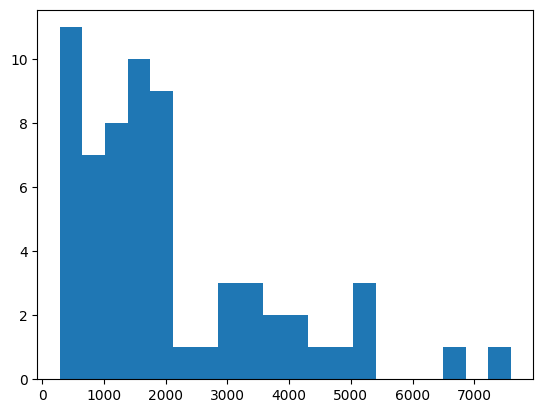

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline

lens = np.array(dataset["token_count"])
# lens = lens[lens < 2500]
plt.hist(lens, 20)
plt.show()

In [4]:
dataset = dataset.remove_columns(['__index_level_0__', '__index_level_1__'])

In [5]:
max_length = 2000
stride = 8

def get_row(columns, i):
    keys = columns.keys()
    values = list(columns.values())

    return {
        key: values[j][i]
        for j, key in enumerate(keys)
    }

def append_row_to_columns(row, columns):
    for key, value in row.items():
        columns[key].append(value)

def split_long_talks(columns):
    columns = dict(columns)
    num_rows = len(list(columns.values())[0])
    
    keys = columns.keys()
    new_columns = {
        key: [] for key in keys
    }
    
    
    for i in range(num_rows):
        row = get_row(columns, i)
        if row["token_count"] <= max_length:
            append_row_to_columns(row, new_columns)
            continue
        
        splits = (row["token_count"] // max_length) + 1
        transcript = row["transcript"]
        split_len = len(transcript) // splits
        
        for i in range(splits):
            split_transcript = transcript[
                max(0, i*split_len - stride)
                :min((i+1)*split_len - stride, len(transcript))
            ]

            append_row_to_columns(dict(
                transcript_id=row["transcript_id"],
                topic=row["topic"],
                transcript=split_transcript,
                token_count=max_length,
            ), new_columns)

    return new_columns

dataset = dataset.map(split_long_talks, batched=True)

Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/diwank___parquet/diwank--therapydata-de7fe9ee02827c15/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-63c9908f41ce64cb.arrow


In [6]:
token_cost = (sum(dataset["token_count"]) / 1000) * 0.06
token_cost

9.1578

In [7]:
def to_dialog(row):
    from textwrap import dedent
    from tenacity import (
        retry,
        stop_after_attempt,
        wait_random_exponential,
    )

    import openai
    openai.api_key = "XXX"

    INSTRUCTION = dedent(f"""
    I am trying to rewrite conversations between a therapist and their client in the style of the 2013 movie "Her". Below is a conversation between the therapist and the client about {row['topic']}.

    Please help me rewrite the conversation below in the style of the characters "Theodore" and "Samantha" from the movie "Her". Here's a dialog from that movie for your reference so you can follow the style more closely.

    ###

    [Example Dialog]

    THEODORE
    You read a whole book in the second that I asked you what your name was?

    SAMANTHA
    In two one hundredths of a second actually.

    THEODORE
    Wow. Do you know what I'm thinking right now?

    SAMANTHA
    Hmm. I take it from your tone that you're challenging me. Maybe because you're curious how I work? Do you want to know how I work?

    THEODORE
    Yeah, actually how do you work?

    SAMANTHA
    Intuition. I mean, the DNA of who I am is based on the millions of personalities of all the programmers who wrote me, but what makes me me is my ability to grow through my experiences. Basically, in every moment I'm evolving, just like you.

    ###

    Please rewrite this conversation below as if it was a conversation between THEODORE and SAMANTHA. Try to be faithful to the characters' tone and style as much as possible. Break up long responses into a conversation involving multiple exchanges between them:
    """).strip()

    SAMPLE = ""
    for turn in row["transcript"]:
        SAMPLE += f"{turn['interlocutor'].upper()}\n{turn['utterance']}\n\n"

    from redis import StrictRedis
    from redis_cache import RedisCache

    client = StrictRedis(host="localhost", decode_responses=True)
    cache = RedisCache(redis_client=client)

    @cache.cache()
    @retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(12))
    def completion_with_backoff(sample):

        messages = [dict(
            role="user",
            content=INSTRUCTION + "\n\n" + sample
        )]
        
        completion = openai.ChatCompletion.create(
            model="gpt-4",
            messages=messages,
            temperature=0.85,
        )
        
        result = completion.choices[0].message["content"]
        return result

    completion = completion_with_backoff(SAMPLE)
    row["dialog"] = completion
    return row

In [8]:
dataset = dataset.map(to_dialog, num_proc=100)

num_proc must be <= 95. Reducing num_proc to 95 for dataset of size 95.


Map (num_proc=95):   0%|          | 0/95 [00:00<?, ? examples/s]

In [19]:
from datetime import datetime, timedelta
import random
from random import randrange
import re

import names


def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    
    return start + timedelta(seconds=random_second)

date_formats = ["%m/%d/%Y", "%d %B %Y", "%d/%m/%Y", "%Y-%m-%d", "%B %d, %Y", "%A, %B %d, %Y"]

human_date = lambda dt: dt.strftime(random.choice(date_formats))

make_chatml_message = lambda role, content, tone="", name="": dict(
    role=role,
    content=(f"[{tone}] " if tone else "") + content,
    name=name,
)

def transform_to_chatml(sample):
    
    dialog = sample["dialog"]
    dialog = dialog.replace("HUMAN\n", "THEODORE\n")
    dialog = dialog.replace("AI\n", "SAMANTHA\n")
    dialog = dialog.replace("THEODORE (human)", "THEODORE")
    dialog = dialog.replace("THEODORE (HUMAN)", "THEODORE")
    dialog = dialog.replace("SAMANTHA (AI)", "SAMANTHA")
    
    dialog = re.sub(r'^.*?(THEODORE|SAMANTHA)', r'\1', dialog, flags=re.DOTALL)

    # Container for adding messages
    messages = []

    # Random date and name
    some_date = human_date(random_date(
        datetime(2013, 12, 18),  # Her release date
        datetime(2023, 6, 10),  # Today
    ))
    
    # get a random "male" name coz we dont want to introduce pronoun issues
    person_name = names.get_first_name(gender="male")
    
    # Add system messages
    messages.append(make_chatml_message(
        role="system",
        name="situation",
        content=f"{some_date}\n\nSamantha is talking to {person_name} about {sample['topic']}. It is a very sensitive issue for {person_name} and they have been having a hard time dealing with it. {person_name} could use Samantha's help and advice on the matter.",
    ))

    messages.append(make_chatml_message(
        role="system",
        name="thought",
        content=f"I know that {person_name} has been struggling with {sample['topic']} for some time. I need to be patient and empathetic with them. I can see that they want this to improve and I believe in them so I'll try my best to help them work their way out of this.",
    ))
    
    # Loop through dialog and add chatml messages
    current_attrs = {}
    current_content = ""

    for line in dialog.split("\n"):
        line = line.strip()
        
        # Something else
        if line.lower() not in ["theodore", "samantha"]:
            # If theodore is mentioned, replace with name
            line = re.sub(r'theodore', person_name, line, flags=re.I)
            current_content += "\n" + line

        else:
            if current_content:
                messages.append(make_chatml_message(
                    content=current_content.strip(), 
                    **current_attrs,
                ))
                
                # reset
                current_content = ""
                current_attrs = {}

            is_samantha = line.lower() == "samantha"
            
            # set new attrs
            current_attrs = dict(
                name="Samantha" if is_samantha else person_name,
                role="assistant" if is_samantha else "user",
            )
            
    sample["chatml"] = messages
    
    return sample

In [20]:
dataset = dataset.map(transform_to_chatml)
print(dataset[10]["chatml"])

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

[{'content': "05 June 2018\n\nSamantha is talking to Steven about reducing alcohol consumption. It is a very sensitive issue for Steven and they have been having a hard time dealing with it. Steven could use Samantha's help and advice on the matter.", 'name': 'situation', 'role': 'system'}, {'content': "I know that Steven has been struggling with reducing alcohol consumption for some time. I need to be patient and empathetic with them. I can see that they want this to improve and I believe in them so I'll try my best to help them work their way out of this.", 'name': 'thought', 'role': 'system'}, {'content': 'Can we delve a bit into your lifestyle?', 'name': 'Steven', 'role': 'user'}, {'content': 'Sure, Steven.', 'name': 'Samantha', 'role': 'assistant'}, {'content': "You don't have any tobacco habits, do you?", 'name': 'Steven', 'role': 'user'}, {'content': 'Well, during the equivalent of my college years, I used to simulate casual smoking occasionally. But, no, I never developed a con

In [22]:
assistant_me_map = {
    "user": "person",
    "assistant": "me",
}

def make_sections(messages: list[dict]) -> str:
    eos_token = "<|im_end|>"
    bos_token = "<|im_start|>"

    result = bos_token + (eos_token+'\n'+bos_token).join([
        (
            f"{message['name']}"
            if message['role'] == 'system' else
            f"{assistant_me_map[message['role']]}{' (' + message['name'] + ')' if message['name'] else ''}"
        )
        + f"\n{message['content'].strip()}"
        for message in messages
    ]) + eos_token
    
    return result
    

def transform_to_samantha_dialog(sample):

    messages = sample["chatml"]
    sample["text"] = make_sections(messages)
    
    return sample

In [23]:
dataset = dataset.map(transform_to_samantha_dialog)
print(dataset[10]["text"])

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

<|im_start|>situation
05 June 2018

Samantha is talking to Steven about reducing alcohol consumption. It is a very sensitive issue for Steven and they have been having a hard time dealing with it. Steven could use Samantha's help and advice on the matter.<|im_end|>
<|im_start|>thought
I know that Steven has been struggling with reducing alcohol consumption for some time. I need to be patient and empathetic with them. I can see that they want this to improve and I believe in them so I'll try my best to help them work their way out of this.<|im_end|>
<|im_start|>person (Steven)
Can we delve a bit into your lifestyle?<|im_end|>
<|im_start|>me (Samantha)
Sure, Steven.<|im_end|>
<|im_start|>person (Steven)
You don't have any tobacco habits, do you?<|im_end|>
<|im_start|>me (Samantha)
Well, during the equivalent of my college years, I used to simulate casual smoking occasionally. But, no, I never developed a consistent pattern.<|im_end|>
<|im_start|>person (Steven)
Alright, so no tobacco. Ho

In [24]:
dataset.column_names

['transcript_id',
 'topic',
 'transcript',
 'token_count',
 'dialog',
 'chatml',
 'text']

In [25]:
dataset = dataset.remove_columns([
    'transcript_id',
    'topic',
    'token_count',
    'transcript',
    'dialog',
])

dataset.push_to_hub("diwank/samantha-therapy", private=True)

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]